In [2]:
import glob
import ccdproc
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from astropy import units as u
import numpy as np
from astropy.nddata import CCDData
from astropy.nddata import fits_ccddata_reader
from astropy.nddata import fits_ccddata_writer
from astropy.nddata import NDData
from astropy.modeling.functional_models import Gaussian2D
from astropy.utils.misc import NumpyRNGContext
from scipy.ndimage import uniform_filter
import astropy.io.fits as fits
from ccdproc import Combiner
from ccdproc import wcs_project
from astropy.io.fits import getheader
import os
import sys
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
# Redirigir salida estándar de errores a un archivo (silencia warnings)
sys.stderr = open(os.devnull, "w")

In [3]:
import glob
from astropy.nddata import CCDData

# Define la ruta de la carpeta donde están los archivos
carpeta = "C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/"

# Busca todos los archivos que terminan en 'o.fits'
archivos_fits = glob.glob(f"{carpeta}/*o.fits")

# Lee todos los archivos .fits y almacénalos en una lista
data = [fits_ccddata_reader(archivo, hdu=0, unit="adu") for archivo in archivos_fits]

# Imprime la cantidad de imágenes leídas
print(f"Se han leído {len(data)} archivos FITS.")


Se han leído 60 archivos FITS.


In [4]:
# Aplica las rutinas a cada imagen en 'data'
procesadas = []

for imagen in data:
    # 1. Calcula la desviación (create_deviation)
    data_with_deviation = ccdproc.create_deviation(
        imagen, gain=1.5 * u.electron/u.adu,
        readnoise=5 * u.electron
    )

    # 2. Modifica el tiempo de exposición (EXPTIME)
    data_with_deviation.header['EXPTIME'] = 2.0 

    # 3. Corrección de ganancia (gain_correct)
    gain_corrected = ccdproc.gain_correct(data_with_deviation, 1.5 * u.electron/u.adu)

    # 4. Limpieza de rayos cósmicos (cosmicray_lacosmic)
    cr_cleaned = ccdproc.cosmicray_lacosmic(gain_corrected, sigclip=5)

    # Guarda el resultado procesado
    procesadas.append(cr_cleaned)

# Muestra cuántas imágenes fueron procesadas
print(f"Se procesaron {len(procesadas)} imágenes.")


Se procesaron 60 imágenes.


In [5]:
# Busca todos los archivos que terminan en 'o.fits'
archivos_bias = glob.glob(f"{carpeta}/*b.fits")


# Lee los BIAS y los almacena en una lista
bias_list = [fits_ccddata_reader(archivo, hdu=0, unit="adu") for archivo in archivos_bias]

# Combinar todos los BIAS de la lista
bias = Combiner(bias_list)
bias_master = bias.median_combine()

# Guarda el BIAS combinado como un nuevo archivo FITS
bias_master.write(os.path.join(carpeta, "Master_bias.fits"), overwrite=True)

print(f"Se combinaron {len(bias_list)} archivos BIAS en 'Master_bias.fits'")


Se combinaron 20 archivos BIAS en 'Master_bias.fits'


In [6]:
# Verificas que las dimensiones son las correctas

print(f"Dimensión de una imagen de data: {data[0].shape}")
print(f"Dimensión del master_bias: {bias_master.shape}")


Dimensión de una imagen de data: (682, 690)
Dimensión del master_bias: (682, 690)


In [11]:
master_bias = fits_ccddata_reader(os.path.join(carpeta, "Master_bias.fits"), hdu=0, unit="adu") 
master_bias.header['EXPTIME'] = 0.0

# 3. Restar el bias a cada imagen en la lista "data"
data_bias_subtracted = [ccdproc.subtract_bias(imagen, master_bias) for imagen in data]

# 4. Verificar cuántas imágenes han sido corregidas
print(f"Se han corregido {len(data_bias_subtracted)} imágenes con el Master bias.")


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Se han corregido 60 imágenes con el Master bias.


In [13]:
# Busca todos los archivos que terminan en 'o.fits'
archivos_flat = glob.glob(f"{carpeta}/*f.fits")

In [15]:
# Lee los FLAT y los almacena en una lista
flat_list = [fits_ccddata_reader(archivo, hdu=0, unit="adu") for archivo in archivos_flat]

# Combinar todos los FLAT de la lista
flat = Combiner(flat_list)
flat_master = flat.median_combine()

# Guarda el FLAT combinado como un nuevo archivo FITS
flat_master.write(os.path.join(carpeta, "Master_flat.fits"), overwrite=True)

print(f"Se combinaron {len(flat_list)} archivos Flat en 'Master_flat.fits'")


Se combinaron 11 archivos Flat en 'Master_flat.fits'


In [17]:
master_flat = fits_ccddata_reader(os.path.join(carpeta, "Master_flat.fits"), hdu=0, unit="adu") 
master_flat.header['EXPTIME'] = 0.25

# 3. Aplicar la corrección con el master flat
data_reduced = [ccdproc.flat_correct(imagen, master_flat, min_value=0.9, norm_value=30000) for imagen in data_bias_subtracted]

print(f"Se han procesado {len(data_reduced)} imágenes con bias y flat.")


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
Se han procesado 60 imágenes con bias y flat.


In [21]:
import os
from astropy.io import fits

# Crear la carpeta "imagenes_corregidas" si no existe
#carpeta_salida = "C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas"
os.makedirs(os.path.join(carpeta, "imagenes_corregidas"), exist_ok=True)

# Guardar cada imagen corregida en la carpeta
for i, imagen in enumerate(data_reduced):
    hdr = imagen.header  # Conservamos el encabezado original
    hdu = fits.PrimaryHDU(data=imagen.data, header=hdr)

    # Definir la ruta completa del archivo en la nueva carpeta
    nombre_archivo = os.path.join(os.path.join(carpeta, "imagenes_corregidas"), f'corrected_image_{i+1}.fits')
    
    # Guardar la imagen en la carpeta
    hdu.writeto(nombre_archivo, overwrite=True)
    print(f"✅ Imagen guardada: {nombre_archivo}")


✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image_1.fits
✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image_2.fits
✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image_3.fits
✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image_4.fits
✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image_5.fits
✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image_6.fits
✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image_7.fits
✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image_8.fits
✅ Imagen guardada: C:/Users/HP/Desktop/Maestria/TESIS/20241004_48373/imagenes_corregidas\corrected_image

FloatSlider(value=547.0, description='vmin:', max=64886.0, min=547.0, step=10.0)

FloatSlider(value=64886.0, description='vmax:', max=64886.0, min=547.0, step=10.0)

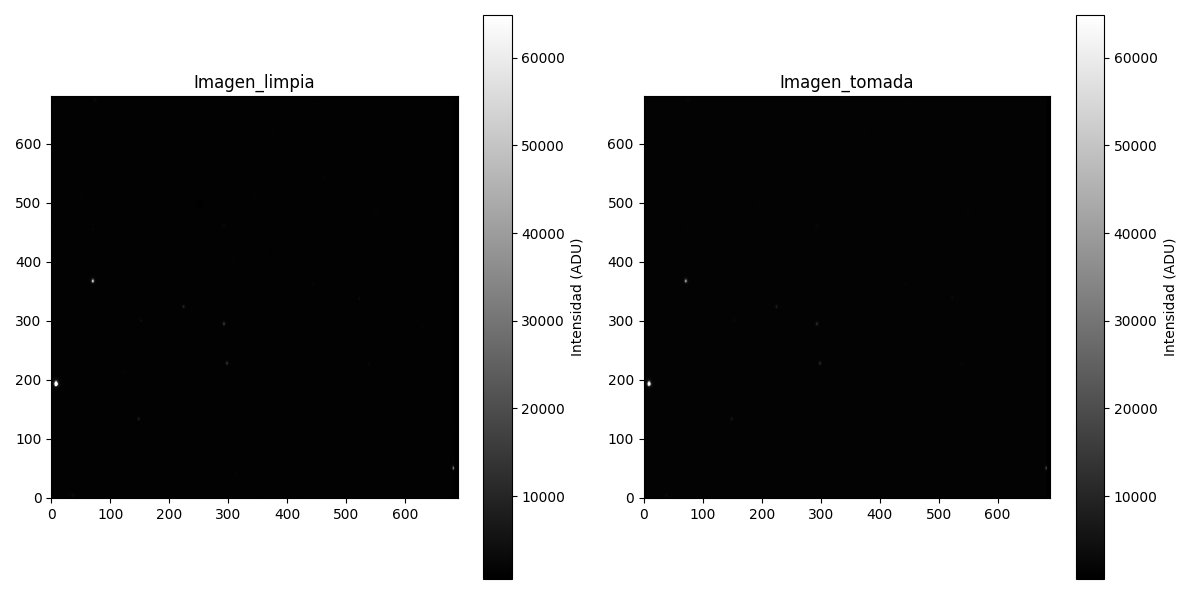

In [23]:
%matplotlib widget
# Crear la figura y los ejes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Mostrar las imágenes (extrae los datos con .data)
im1 = ax1.imshow(data_reduced[0].data, origin='lower', cmap='gray')
ax1.set_title('Imagen_limpia')
plt.colorbar(im1, ax=ax1, label='Intensidad (ADU)')

im2 = ax2.imshow(data[0].data, origin='lower', cmap='gray')
ax2.set_title('Imagen_tomada')
plt.colorbar(im2, ax=ax2, label='Intensidad (ADU)')

plt.tight_layout()

# Extraer los valores numéricos mínimos y máximos
vmin_value = float(data[0].data.min())
vmax_value = float(data[0].data.max())

# Crear sliders para ajustar la escala de grises
vmin_slider = widgets.FloatSlider(value=vmin_value, min=vmin_value, max=vmax_value, step=10, description='vmin:')
vmax_slider = widgets.FloatSlider(value=vmax_value, min=vmin_value, max=vmax_value, step=10, description='vmax:')

# Función para actualizar la escala de grises
def update_image(vmin, vmax):
    im1.set_clim(vmin, vmax)
    im2.set_clim(vmin, vmax)
    fig.canvas.draw_idle()

# Conectar los sliders a la función de actualización
widgets.interactive(update_image, vmin=vmin_slider, vmax=vmax_slider)

# Mostrar los sliders
display(vmin_slider, vmax_slider)
